# Homework Set 4

In [1]:
%pylab inline 
import pandas as pd
import inst, fmt

Populating the interactive namespace from numpy and matplotlib


## Problem 1: 

Implement the Thomas algorithm for solving tridiagonal linear systems:

Do your own reading and research on <a href=http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm>Thomas algorithm</a>  and implement and test it in Python.

### Problem 1 Solution:

In [2]:
import numpy as np

# Self implementation of the Thomas algorithm for solving tridiagonal linear systems: Mx = d
# Input:
#   M: The tridiagonal matrix
#   d: The vector on the right hand side
# Output:
#   xArray: The vector x that satsifies Mx = d
def Thomas(M, d):
    dim = len(M) # The dimension of tridiagonal matrix M
    
    # When M is rank-deficient, this linear system cannot have unique solution, so raising error
    if (np.linalg.matrix_rank(M) < dim):
        raise RuntimeError('Tridiagonal matrix is rank deficient.')
    # When M is 1x1, we can directly solve this linear system 
    if (dim == 1):
        return np.array([d[0] / M[0, 0]])
    
    # Initialize arrays to retrieve non-zero entries in M
    aArray, bArray, cArray = np.zeros(dim), np.zeros(dim), np.zeros(dim)   
    dArray = d.copy() # The array that stores medium values required by back substitution of Thomas algorithm    
    xArray = np.zeros(dim) # The array that stores results
    
    # Retrieve non-zero entries in M
    for i in range(dim):
        if (i == 0):
            bArray[i] = M[i, i]
            cArray[i] = M[i, i + 1]
        elif (i == dim - 1):
            aArray[i] = M[i, i - 1]
            bArray[i] = M[i, i]
        else:
            aArray[i] = M[i, i - 1]
            bArray[i] = M[i, i]
            cArray[i] = M[i, i + 1]
    
    # Compute and stores medium values
    for i in range(1, dim):
        w = aArray[i] / bArray[i - 1]
        bArray[i] = bArray[i] - w * cArray[i - 1]
        dArray[i] = dArray[i] - w * dArray[i - 1]
    
    # Apply back substitution to compute final results
    for i in range(dim - 1, -1, -1):
        if (i == dim - 1):
            xArray[i] = dArray[i] / bArray[i]
        else:
            xArray[i] = (dArray[i] - cArray[i] * xArray[i + 1]) / bArray[i]
            
    return xArray

In [3]:
# Test for my Thomas algorithm program

# 1-D
M1, d1 = np.matrix([[1]]), np.array([2])
x1_tho = Thomas(M1, d1)
x1_np = np.linalg.solve(M1, d1)
print("Check if my Thomas algorithm program works for 1 dimensional tridiagonal matrix:", np.allclose(x1_tho, x1_np))

# 2-D
M2, d2 = np.matrix([[1, 2], [3, 4]]), np.array([1, 1])
x2_tho = Thomas(M2, d2)
x2_np = np.linalg.solve(M2, d2)
print("Check if my Thomas algorithm program works for 2 dimensional tridiagonal matrix:", np.allclose(x2_tho, x2_np))

# 3-D or more
M3, d3 = np.matrix([[1, 2, 0], [3, 4, 5], [0, 6, 7]]), np.array([1, 1, 1])
x3_tho = Thomas(M3, d3)
x3_np = np.linalg.solve(M3, d3)
print("Check if my Thomas algorithm program works for tridiagonal matrix with dimensinos > 2:", np.allclose(x3_tho, x3_np))

Check if my Thomas algorithm program works for 1 dimensional tridiagonal matrix: True
Check if my Thomas algorithm program works for 2 dimensional tridiagonal matrix: True
Check if my Thomas algorithm program works for tridiagonal matrix with dimensinos > 2: True


In [14]:
# Test if error can be raised when M is rank-deficient
Merr, derr = np.matrix([[1, 1, 0], [1, 2, 1], [0, 1, 1]]), np.array([1, 1, 1])
xerr = Thomas(Merr, derr)

RuntimeError: Tridiagonal matrix is rank deficient.

The Thomas algorithm for solving tridiagonal linear systems is implemented above. <br>

Also, the tests of my Thomas algorithm program are showed above, it consists of two parts: <br>

(1) For the array of $a_i, c_i$, we know that $a_1 = c_n = 0$. So we should pay attention to the general case ($n > 2$), and the edge case ($n \leq 2$) separately to see if the program works well. <br>

(2) When the tridiagonal matrix is rank-deficient, the Thomas algorithm will fail since $b_i = 0$ will happen when computing medium values, and the solution is not unique. So we should test if the program raises error when input $M$ is rank-deficient. <br>

## Problem 2

Given the following benchmark swap quotes for USD, suppose all swap coupons are paid semi-annually:

In [5]:
mats = np.array([1, 2, 3, 5, 7, 10, 12, 15, 20, 25]) * 1.
par = np.array([.042, .043, .047, .054, .057, .06, .061, .059, .056, .0555])

df_swap = pd.DataFrame(np.array([par]).T*100, columns=["Par Rate (%)"],
                       index=map(lambda m: '%dY' % m, mats))
fmt.displayDF(df_swap.T, 2, 2)

,1Y,2Y,3Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
Par Rate (%),4.2,4.3,4.7,5.4,5.7,6.0,6.1,5.9,5.6,5.5


The swap pricers are provided by the python class ```Swap``` and the pricing function ```priceSwap```, both are defined in <a href=https://raw.githubusercontent.com/yadongli/nyumath2048/master/lib/swap.py>swap.py</a> under the folder nyumath2048/lib of the github repository.

Note the following assumptions of the swap pricer provided:
* it prices a receiver swap, you need to flip the sign to price a payer swap
* it ignores important details, such as day count conventions, do not use this code to trade!

The following are some sample codes of how to use the swap pricers:

In [6]:
from swap import Swap, priceSwap
import lin

# the pricing function if curve(t) is the cumulative yield, ie, -log(b(t))
def y2pv(swap, curve) :
    discf = lambda ts: np.exp(-curve(ts))
    return priceSwap(swap, discf)

# create the benchmark instruments
bm_swaps = {Swap(m, c, 2) : 0 for m, c in zip (mats, par)}

# price a single swap with a straight curve in y(t)
flat = lin.RationalTension(lbd = 5.)
flat.build(mats, mats*.04) # create a dummy curve of flat 0.04 rate

pvs = {swap.maturity : y2pv(swap, flat) for swap in bm_swaps.keys()}
print("PV by maturity")
print("\n".join(["%.2g Y : %.4g" % (m, v) for m, v in pvs.items()]))

PV by maturity
1 Y : 0.00155
2 Y : 0.004943
3 Y : 0.01846
5 Y : 0.06101
7 Y : 0.1003
10 Y : 0.1599
12 Y : 0.1943
15 Y : 0.2077
20 Y : 0.2126
25 Y : 0.2362


1. Explain what is the purpose of the +1e-6 in the first line of the ```priceSwap``` function
2. Use the market data above to bootstrap the IR curve by interpolating the cumulative yield $y(t) = -\log(b(t))$ with tension spline, where $b(t)$ is the discount factor (i.e., the price of risk free zero coupon bonds). After bootstrapping the curve, re-price the benchmark instruments using the bootstrapped curve, and compute the L-2 norm of the absolute pricing errors. Show how the pricing error of the bootstrapped curve depend on the tension parameter $\lambda$.
3. Using the iteration technique to reduce the L-2 norm of the error below 1bps, how many iteration is needed for the error to go below 1bps?
4. From the curve built in the previous step, compute both the $y(t)$ and the instantaneous forward rate $f(t) = -\frac{1}{b(t)}\frac{d b(t)}{d t} = \frac{d y(t)}{dt}$, and show how their shapes change with the tension parameter $\lambda$. In addition, compare the changes in the instantaneous forward rates with 1bps change in the 5Y par swap rate. You can use the ```deriv()``` method in the Tension spline class. 
6. Repeat the previous step, but directly interpolating the forward rates $f(t)$, and comment on whether it is suitable in practice.
5. [extra credit] Build the curve by interpolating the zero rate with tension spline instead, i.e, $r(t) = \frac{y(t)}{t}$, compare how the forward rates shape and perturbations differ from those obtained in step 4, and comment on the pro and cons between interpolating $r(t)$ and $y(t)$.
7. [extra credit] write your own bootstrap function instead of calling those provided by the class library

Hint: 
* write your code in a modular and reusable way; you can re-use the code provided as part of the class lecture, but you get extra credit if you can write your own bootstrapping. The source code of the inst package is hidden from you, but you can figure out how to use them by reading their docstring with ```help()```, please use the python codes in the lecture slides as examples.
* be careful with the choice of boundary for the root search, allow negative rates often helps stabilizing the bootstrapping, even though it does not make economic sense
* in step 5, you may have to mix the old and new results to stabilize the iteration, (e.g., use ```mixf=0.5``` in the ```inst.iterboot``` function, or your own)

### Problem 2 Solution:

1. <br>

np.arange is a method that returns an array of even spaced values, with the interval include start point and exclude end point. 

However, we should include the longest maturity in this array, so we set the end point as "longest maturity + 1e-6" to include the point of longest maturity.

Also, 1e-6 is a value small enough so the end point is exactly the longest maturity, not "longest maturity + freq".

In [7]:
help(inst.iterboot)

Help on function iterboot in module inst:

iterboot(bms, pfunc, x0, lbd=0.0, bds=[-1, 1], its=5, mixf=0.0, make_curve=<class 'lin.RationalTension'>)
    bootstrap a tension spline curve with multiple iterations
    Args:
        bms: a dictionary of benchmark instruments and their PVs {inst : pv}
        pfunc: a function that computes the pv of an instrument pfunc(inst, curve)
        x0: the curve's start value at time 0
        lbd: the tension parameter 
        bds: the boundary of curve points [lowerbound, upperbound]
        its: number of iterations
        mixf: the mixing factor between the new and old values for the next iteration, 0: take the new value
    Returns:
        tsit: the curve built
        e: the errors in pv after each iteration



,$\lambda$=0,$\lambda$=2,$\lambda$=10,$\lambda$=100
L-2 norm of the absolute pricing errors,0.008157,0.005588,0.00255,0.0003693


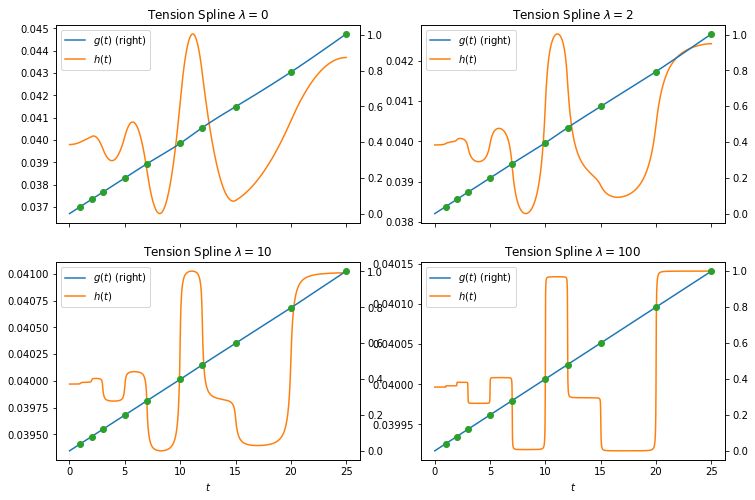

In [8]:
# work for question 2

# pv is computed by known cumulative yield y(t)
# update the pv for swaps dictionary bm_swaps
for swap in bm_swaps.keys():
    bm_swaps[swap] = pvs[swap.maturity]

# define the time step for swaps maturities, time step should be between 0 and 25Y
xs_swaps = np.arange(0.01, 25, 0.01)

# this function is from lecture notebook
# plot the result of inst.iterboot
def plotboot(tsit, lbd, ax, tagsf) :
    xlabel('Time')    
    
    lbd_tag = '$\\lambda=%.f$' % lbd
    df = pd.DataFrame({'$t$':xs_swaps}).set_index(['$t$'])
    
    for tag, f in tagsf :
        df[tag] = f(tsit, xs_swaps) 
    
    df.plot(ax = ax, secondary_y = [tagsf[0][0]], title = 'Tension Spline ' + lbd_tag)
    plot(mats, tsit(mats), 'o')

tagsf = [("$g(t)$", lambda cv, xs_swaps : cv(xs_swaps)), ("$h(t)$", lambda cv, xs_swaps : cv.deriv(xs_swaps))]

lbds = [0, 2, 10, 100]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12, 8])

# initialize the arrays to store pv errors and re-priced pv
es_swaps = []
newPrice = []

# this part is mainly from lecture notebook
for lbd, ax in zip(lbds, axes.flatten()) :
    tsit, e = inst.iterboot(bm_swaps, y2pv, lbd=lbd, bds = [-5, 5], x0=0, its=1)
    plotboot(tsit, lbd, ax, tagsf)
    # record pv errors
    es_swaps.append(e[0])
    # record re-priced pv
    newPV = {swap.maturity : y2pv(swap, tsit) for swap in bm_swaps.keys()}
    newPV_value = np.array(list(newPV.values()))
    newPrice.append(newPV_value)

# compute the L-2 norm for different absolute pv errors computed by different lambda
errNorm = np.array([np.linalg.norm(np.absolute(err), 2) for err in es_swaps])

# display the result
df_newPrice = pd.DataFrame(newPrice, index=['$\\lambda$=%g' % l for l in lbds], 
                           columns = ['%gY' % t for t in mats])
fmt.displayDFs(df_newPrice, fmt = "4f", fontsize=2, headers = ['Benchmark instruments re-priced by the bootstrapped curve'])
fmt.displayDF(pd.DataFrame(errNorm.reshape(1, 4), index = ['L-2 norm of the absolute pricing errors'], 
                           columns = ['$\\lambda$=%g' % l for l in lbds]), fmt = "4g", fontsize=4)

2. <br>

(1) By interpolating the cumulative yield $y(t)=−\text{log}(b(t))$ with tension spline, the plot of bootsrapped IR curve with different $\lambda$ is showed above. <br>

(2) After re-pricing the benchmark instruments using the bootstrapped curve, the new PV and the L-2 norm of the absolute pricing errors are showed above. <br>

(3) We may conclude that the larger the tension parameter $\lambda$, the less the L-2 norm of the absolute pricing errors. <br>

In [9]:
# work for question 3

# initialize the arrays to store the number of iterations
iterRecord = np.zeros(len(lbds))

# loop for all lambda candidates
for i in range(len(lbds)):
    j = 1
    tsit, e = inst.iterboot(bm_swaps, y2pv, lbd=lbd, bds = [-5, 5], x0=0, its=j)
    # loop until the L-2 norm for absolute pv errors is less than 1bps
    while (np.linalg.norm(np.absolute(e[j - 1]), 2) >= 1e-4):   
        j += 1
        tsit, e = inst.iterboot(bm_swaps, y2pv, lbd=lbd, bds = [-5, 5], x0=0, its=j)
    # record the number
    iterRecord[i] = j

# display the result
fmt.displayDF(pd.DataFrame(iterRecord.reshape(1, 4), index = ['Number of iterations needed when L-2 norm of the error go below 1bps'], 
                           columns = ['$\\lambda$=%g' % l for l in lbds]), fmt = "4g", fontsize=4)

,$\lambda$=0,$\lambda$=2,$\lambda$=10,$\lambda$=100
Number of iterations needed when L-2 norm of the error go below 1bps,2,2,2,2


3. <br>

The number of iterations needed to make the error go below 1bps is showed above. <br>

For $\lambda = 0, 2, 10, 100$, number of iterations needed are all 2. <br>

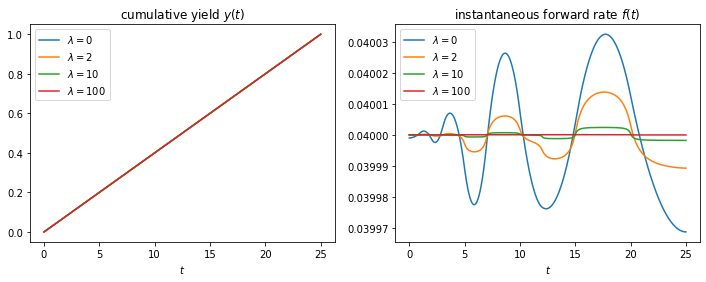

In [10]:
# work for question 4

# initialize the arrays to store the bootstrap curve whose pv error is below 1bps
cvs_swaps = []
for i in range(len(lbds)):
    cv, e = inst.iterboot(bm_swaps, y2pv, lbd=lbds[i], bds = [-5, 5], x0=0, its=int(iterRecord[i]))
    # record the curve
    cvs_swaps.append(cv)

# plot cumulative yield y(t) and instantaneous forward rate f(t) by recorded curve
tags_swaps = ['$\\lambda=%.f$' % l for l in lbds]
    
figure(figsize=[12, 4])
subplot(1, 2, 1)
plot(xs_swaps, np.array([cv(xs_swaps) for cv in cvs_swaps]).T);
legend(tags_swaps, loc='best');
title('cumulative yield $y(t)$')
xlabel('$t$')

subplot(1, 2, 2)
plot(xs_swaps, np.array([cv.deriv(xs_swaps) for cv in cvs_swaps]).T);
legend(tags_swaps, loc='best');
title('instantaneous forward rate $f(t)$');
xlabel('$t$');

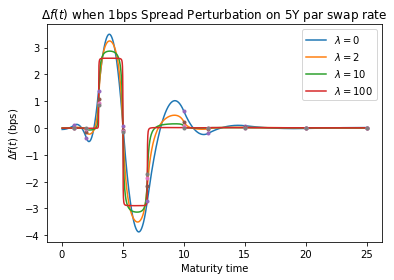

In [11]:
# define the new dictionary of swaps that contains pertubation
bms_ps_swaps = {k if k.maturity != 5. else Swap(k.maturity, k.coupon-(1e-4), k.freq) : v 
        for k, v in bm_swaps.items()}

# initialize the arrays to store the bootstrap curve by data after pertubation
cvp1_swaps = []
for i in range(len(lbds)):
    cv, e = inst.iterboot(bms_ps_swaps, y2pv, lbd=lbds[i], bds = [-5, 5], x0=0, its=int(iterRecord[i]))
    # record the curve
    cvp1_swaps.append(cv)

# plot the difference of f(t) between original data and data after pertubation
figure(figsize=[6, 4])
pertf_swaps = lambda f, g : lambda xs_swaps : f.deriv(xs_swaps) - g.deriv(xs_swaps)
plot(xs_swaps, 1e4*np.array([pertf_swaps(f, g)(xs_swaps) for f, g in zip(cvs_swaps, cvp1_swaps)]).T);
xlabel('Maturity time')
ylabel('$\Delta f(t)$ (bps)')
title('$\Delta f(t)$ when 1bps Spread Perturbation on 5Y par swap rate')
legend(tags_swaps, loc='best');
plot(mats, 1e4*np.array([pertf_swaps(f, g)(mats) for f, g in zip(cvs_swaps, cvp1_swaps)]).T, '.');

4. <br>

(1) The plot of the cumulative yield $y(t)$ and the instantaneous forward rate $f(t)$ built by bootstrapped curve is showed above. <br>

$\quad \quad$ (a) For cumulative yield $y(t)$, different tension parameter $\lambda$ does not change the curve shape.
    
$\quad \quad$ (b) For instantaneous forward rate $f(t)$, $f(t)$ will be flatter with greater $\lambda$.
    
(2) The plot of the changes in the instantaneous forward rates $\Delta f(t)$ with 1bps change in the 5Y par swap rate is also showed above. <br>

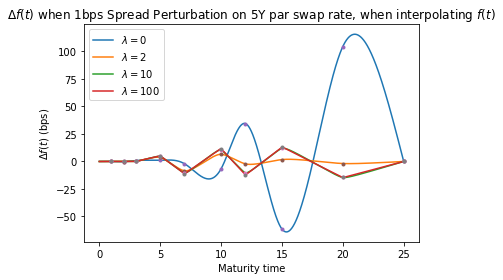

In [12]:
# work for question 5

import warnings
warnings.filterwarnings('ignore')

# build initial forward rate curve f(t) consistent with initial y(t): dummy curve of flat 0.04 rate
fwd = lin.RationalTension(lbd = 5.)
fwd.build(xs_swaps, .04*np.ones(len(xs_swaps)))

# define a function to compute pv of swaps given forward rate curve
# this function is modified by "y2pv" given in the lecture notebook
def f2pv(swap, curve) :
    discf = inst.fwd2disc(curve)
    return priceSwap(swap, discf)

# compute pv by initial forward rate curve
pvs_fwd = {swap.maturity : f2pv(swap, fwd) for swap in bm_swaps.keys()}

# define the new dictionary of swaps with its pv computed by initial forward rate curve
bm_swaps_fwd = {swap : pvs_fwd[swap.maturity] for swap in bm_swaps.keys()}

# define the new dictionary of swaps that contains pertubation and fwd
bms_ps_swaps_fwd = {k if k.maturity != 5. else Swap(k.maturity, k.coupon-(1e-4), k.freq) : v 
        for k, v in bm_swaps_fwd.items()}

# initialize the arrays to store the bootstrap curve after by interpolating f(t)
cvs_swaps_fwd = []
for i in range(len(lbds)):
    cv, e = inst.iterboot(bm_swaps_fwd, f2pv, lbd=lbds[i], bds = [-5, 5], x0=0, its=int(iterRecord[i]))
    # record the curve
    cvs_swaps_fwd.append(cv)

# initialize the arrays to store the bootstrap curve by data after pertubation, when interpolating f(t)
cvp1_swaps_fwd = []
for i in range(len(lbds)):
    cv, e = inst.iterboot(bms_ps_swaps_fwd, f2pv, lbd=lbds[i], bds = [-5, 5], x0=0, its=int(iterRecord[i]))
    # record the curve
    cvp1_swaps_fwd.append(cv)

# plot the difference of f(t) between original data and data after pertubation by interpolating f(t)
figure(figsize=[6, 4])
pertf_swaps_fwd = lambda f, g : lambda xs_swaps : f(xs_swaps) - g(xs_swaps)
plot(xs_swaps, 1e4*np.array([pertf_swaps_fwd(f, g)(xs_swaps) for f, g in zip(cvs_swaps_fwd, cvp1_swaps_fwd)]).T);
xlabel('Maturity time')
ylabel('$\Delta f(t)$ (bps)')
title('$\Delta f(t)$ when 1bps Spread Perturbation on 5Y par swap rate, when interpolating $f(t)$')
legend(tags_swaps, loc='best');
plot(mats, 1e4*np.array([pertf_swaps_fwd(f, g)(mats) for f, g in zip(cvs_swaps_fwd, cvp1_swaps_fwd)]).T, '.');

5. <br>

To consistent with $y(t) = 0.04t$, the initial forward rate curve should be $f(t) = y^{'}(t) = 0.04$

By interpoltaing $f(t)$, the plot of changes in the instantaneous forward rates $\Delta f(t)$ with 1bps change in the 5Y par swap rate is showed above.

From this plot, we may conclude that directly interpolating $f(t)$ is not suitable in practice. Because the resulting curve is not numerically stable, a small pertubation will cause a great change of $f(t)$.

The change $\Delta f(t)$ will be greater with longer maturities and smaller $\lambda$.

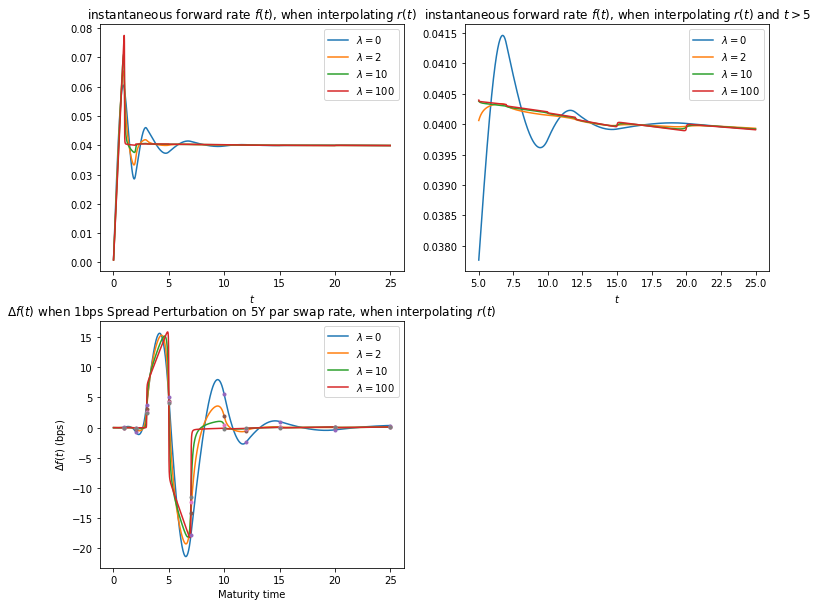

In [13]:
# work for question 6

# build initial zero rate curve f(t) consistent with initial y(t): dummy curve of flat 0.04 rate
zero = lin.RationalTension(lbd = 5.)
zero.build(xs_swaps, .04*np.ones(len(xs_swaps)))

# define a function to compute pv of swaps given zero rate curve
# this function is modified by "y2pv" given in the lecture notebook
def z2pv(swap, curve) :
    discf = inst.zero2disc(curve)
    return priceSwap(swap, discf)

# compute pv by initial zero rate curve
pvs_zero = {swap.maturity : z2pv(swap, zero) for swap in bm_swaps.keys()}

# define the new dictionary of swaps with its pv computed by initial zero rate curve
bm_swaps_zero = {swap : pvs_zero[swap.maturity] for swap in bm_swaps.keys()}

# define the new dictionary of swaps that contains pertubation and zero rate curve
bms_ps_swaps_zero = {k if k.maturity != 5. else Swap(k.maturity, k.coupon-(1e-4), k.freq) : v 
        for k, v in bm_swaps_zero.items()}

# initialize the arrays to store the bootstrap curve after by interpolating r(t)
cvs_swaps_zero = []
for i in range(len(lbds)):
    cv, e = inst.iterboot(bm_swaps_zero, z2pv, lbd=lbds[i], bds = [-6, 6], x0=0, its=int(iterRecord[i]))
    # record the curve
    cvs_swaps_zero.append(cv)

# initialize the arrays to store the bootstrap curve by data after pertubation, when interpolating r(t)
cvp1_swaps_zero = []
for i in range(len(lbds)):
    cv, e = inst.iterboot(bms_ps_swaps_zero, z2pv, lbd=lbds[i], bds = [-6, 6], x0=0, its=int(iterRecord[i]))
    # record the curve
    cvp1_swaps_zero.append(cv)
    
figure(figsize=[12, 10])

# plot instantaneous forward rate f(t) by recorded curve
subplot(2, 2, 1)
plot(xs_swaps, np.array([cv.deriv(xs_swaps) * xs_swaps + cv(xs_swaps) for cv in cvs_swaps_zero]).T);
legend(tags_swaps, loc='best');
title('instantaneous forward rate $f(t)$, when interpolating $r(t)$');
xlabel('$t$');

subplot(2, 2, 2)
plot(xs_swaps[500:], np.array([cv.deriv(xs_swaps[500:]) * xs_swaps[500:] + cv(xs_swaps[500:]) for cv in cvs_swaps_zero]).T);
legend(tags_swaps, loc='best');
title('instantaneous forward rate $f(t)$, when interpolating $r(t)$ and $t > 5$');
xlabel('$t$');

# plot the difference of f(t) between original data and data after pertubation by interpolating r(t)
subplot(2, 2, 3)
pertf_swaps_zero = lambda f, g : lambda xs_swaps : f(xs_swaps) + xs_swaps * f.deriv(xs_swaps)- g(xs_swaps) - xs_swaps * g.deriv(xs_swaps)
plot(xs_swaps, 1e4*np.array([pertf_swaps_zero(f, g)(xs_swaps) for f, g in zip(cvs_swaps_zero, cvp1_swaps_zero)]).T);
xlabel('Maturity time')
ylabel('$\Delta f(t)$ (bps)')
title('$\Delta f(t)$ when 1bps Spread Perturbation on 5Y par swap rate, when interpolating $r(t)$')
legend(tags_swaps, loc='best');
plot(mats, 1e4*np.array([pertf_swaps_zero(f, g)(mats) for f, g in zip(cvs_swaps_zero, cvp1_swaps_zero)]).T, '.');

6. <br>

To consistent with $y(t) = 0.04t$, the initial zero rate curve should be $\displaystyle r(t) = \frac{y(t)}{t} = 0.04$

By interpolating $\displaystyle r(t)$, the plot of the instantaneous forward rate $f(t)$, and the changes in the instantaneous forward rates $\Delta f(t)$ with 1bps change in the 5Y par swap rate, are showed above.

After comparing the plot of interpolating $r(t)$ and the plot of interpolating $y(t)$, we may find that 

(1) The numerical stability of the curve $f(t)$ obtained by interpolating $y(t)$ is better than the curve obtained by interpolating $r(t)$. When we do a 1bps spread pertubation, the change $\Delta f(t)$ is smaller for $f(t)$ obtained by interpolating $y(t)$.

(2) The curve $f(t)$ obtained by interpolating $y(t)$ produce precise and stable value when the maturity $t$ is small, but will be more fluctuated as $t$ increases. Conversely, the curve $f(t)$ obtained by interpolating $r(t)$ is unstable and imprecise when $t$ is small, but will be more stable and converge to precise value as $t$ increases.

Therefore, we may interpolate $y(t)$ if we want more numerically stable $f(t)$ or want to know $f(t)$ when $t$ is small, and may interpolate $r(t)$ if we want to know $f(t)$ when $t$ is large.